## Feature Engineering & Model Testing

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from util.data_access import load_data
from util.preprocess import preprocess, cat_columns
from util.tracking import get_metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv()
SEED = 42
import datetime

import os
import mlflow
mlflow.set_tracking_uri('http://35.246.127.179')


EXPERIMENT_NAME = 'Fraud Model Feature Engineering Loop'

try:
    EXPERIMENT_ID = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
except Exception as e:
    print(e)
    EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

In [2]:
df_raw = load_data()

MAX_MERCHANT_TRANSACTIONS = df_raw.groupby('merchant')['fraud'].count().max()
df_raw['merchant_amount_ma_total'] = df_raw.groupby(['merchant'])['amount'].transform(lambda x: x.rolling(MAX_MERCHANT_TRANSACTIONS,1).mean())
df_raw['merchant_amount_ma_50'] = df_raw.groupby(['merchant'])['amount'].transform(lambda x: x.rolling(100,1).mean())
df_raw['merchant_amount_ma_10'] = df_raw.groupby(['merchant'])['amount'].transform(lambda x: x.rolling(10,1).mean())
df_raw['merchant_amount_ma_5'] = df_raw.groupby(['merchant'])['amount'].transform(lambda x: x.rolling(5,1).mean())
df_raw['merchant_amount_ma_3'] = df_raw.groupby(['merchant'])['amount'].transform(lambda x: x.rolling(3,1).mean())
df_raw['merchant_amount_moving_max'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(MAX_MERCHANT_TRANSACTIONS,1).max())

MAX_CUSTOMER_TRANSACTIONS = df_raw.groupby('customer')['fraud'].count().max()
df_raw['customer_amount_ma_total'] = df_raw.groupby(['customer'])['amount'].transform(lambda x: x.rolling(MAX_CUSTOMER_TRANSACTIONS, 1).mean())
df_raw['customer_amount_ma_10'] = df_raw.groupby(['customer'])['amount'].transform(lambda x: x.rolling(10, 1).mean())
df_raw['customer_amount_ma_5'] = df_raw.groupby(['customer'])['amount'].transform(lambda x: x.rolling(2, 1).mean())
df_raw['customer_amount_moving_max'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(MAX_CUSTOMER_TRANSACTIONS,1).max())

MAX_CATEGORY_TRANSACTIONS = df_raw.groupby('customer')['fraud'].count().max()
df_raw['category_amount_ma_total'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(MAX_CATEGORY_TRANSACTIONS,1).mean())
df_raw['category_amount_ma_100'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(100,1).mean())
df_raw['category_amount_ma_10'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(10,1).mean())
df_raw['category_amount_moving_max'] = df_raw.groupby(['category'])['amount'].transform(lambda x: x.rolling(MAX_CATEGORY_TRANSACTIONS,1).max())

df_raw['transactions_completed'] = 1
df_raw['customer_transaction_number'] = df_raw.groupby(['customer'])['transactions_completed'].transform(lambda x: x.rolling(MAX_CUSTOMER_TRANSACTIONS, 1).sum())
df_raw['merchant_transaction_number'] = df_raw.groupby(['merchant'])['transactions_completed'].transform(lambda x: x.rolling(MAX_MERCHANT_TRANSACTIONS, 1).sum())
df_raw['has_comitted_fraud_before'] = df_raw.groupby('customer')['fraud'].transform(lambda x: x.shift().rolling(300,1).max()).fillna(0)

## Amount transacted the day before
amount_transacted_daily_by_category = df_raw.groupby(['category','step'])['amount'].mean().rename('mean_category_amount_previous_step').reset_index()
amount_transacted_daily_by_category['step'] = amount_transacted_daily_by_category['step'] + 1
amount_transacted_daily_by_category
df_raw = df_raw.merge(amount_transacted_daily_by_category,how='left', on=['category','step'])
df_raw['mean_category_amount_previous_step'] = df_raw['mean_category_amount_previous_step'].fillna(0)


#Add categorical dummies
cat_dummies = pd.get_dummies(df_raw[['gender','category','age']])
cat_dummy_cols = cat_dummies.columns


train_step_cutoff = df_raw['step'].quantile(0.8)
train_idx = df_raw[df_raw.step <= train_step_cutoff].index
valid_idx =  df_raw[df_raw.step > train_step_cutoff].index
df_train_raw = df_raw.iloc[train_idx,:]
df_valid_raw = df_raw.iloc[valid_idx,:]
X_train_raw, y_train = df_train_raw.drop('fraud',axis=1), df_train_raw.loc[:,'fraud']
X_valid_raw, y_valid = df_valid_raw.drop('fraud',axis=1), df_valid_raw.loc[:,'fraud']

In [3]:
drop_columns = ['zipMerchant','zipcodeOri']
X_train = preprocess(X_train_raw, cat_columns, drop_columns)
X_valid = preprocess(X_valid_raw, cat_columns, drop_columns)




In [25]:
model = lgb.LGBMClassifier(
    is_unbalance=True,
    max_depth=5,
    n_estimators=200,
    num_leaves=40,
    random_state=SEED,
    n_jobs=-1
)

_cat_columns = [
    'category',
    'has_comitted_fraud_before',
]
num_columns = [
    'customer_transaction_number',
    'step',
    'amount',
    'merchant_amount_ma_total',
    'merchant_amount_ma_50',
    'merchant_amount_ma_10',
    'merchant_amount_ma_5',
    'merchant_amount_ma_3',
    'merchant_amount_moving_max',
    'customer_amount_ma_total',
    'customer_amount_ma_10',
    'customer_amount_ma_5',
    'customer_amount_moving_max',
    'category_amount_ma_total',
    'category_amount_ma_100',
    'category_amount_ma_10',
    'category_amount_moving_max',
    'mean_category_amount_previous_step',
    'merchant_transaction_number',
]
columns = [*num_columns, *_cat_columns]

train_data = X_train.loc[:,columns]
valid_data = X_valid.loc[:,columns]

_cat_columns_idx = [train_data.columns.get_loc(i) for i in _cat_columns]

from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(model,param_grid={},n_jobs=-1 )

model.fit(train_data, y_train, categorical_feature=_cat_columns_idx)

Using categorical_feature in Dataset.


LGBMClassifier(is_unbalance=True, max_depth=5, n_estimators=200, num_leaves=40,
               random_state=42)

In [26]:
with mlflow.start_run(experiment_id='3') as run:
    #mlflow.log_param('Columns', columns)
    mlflow.log_param('Train Data Dimension', train_data.shape)     
    mlflow.log_param('Train Target Bad Rate', y_train.mean())     
    mlflow.log_param('Valid Data Dimension', valid_data.shape)     
    mlflow.log_param('Valid Target Dimension', y_valid.mean())     

    mlflow.log_param('Model Type', model.__class__.__name__)
    y_pred_train = model.predict(train_data)
    y_pred_proba_train = model.predict(train_data)
    train_metrics = get_metrics(y_train,y_pred_train,y_pred_proba_train)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Train {key}', val)

    y_pred_valid = model.predict(valid_data)
    y_pred_proba_valid = model.predict(valid_data)
    train_metrics = get_metrics(y_valid,y_pred_valid,y_pred_proba_valid)

    for key, val in train_metrics.items():
        mlflow.log_metric(f'Validation {key}', val)

In [27]:
import shap
explainer = shap.TreeExplainer(model)
explain_data = train_data.sample(frac=0.1)
shap_values = explainer.shap_values(explain_data)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


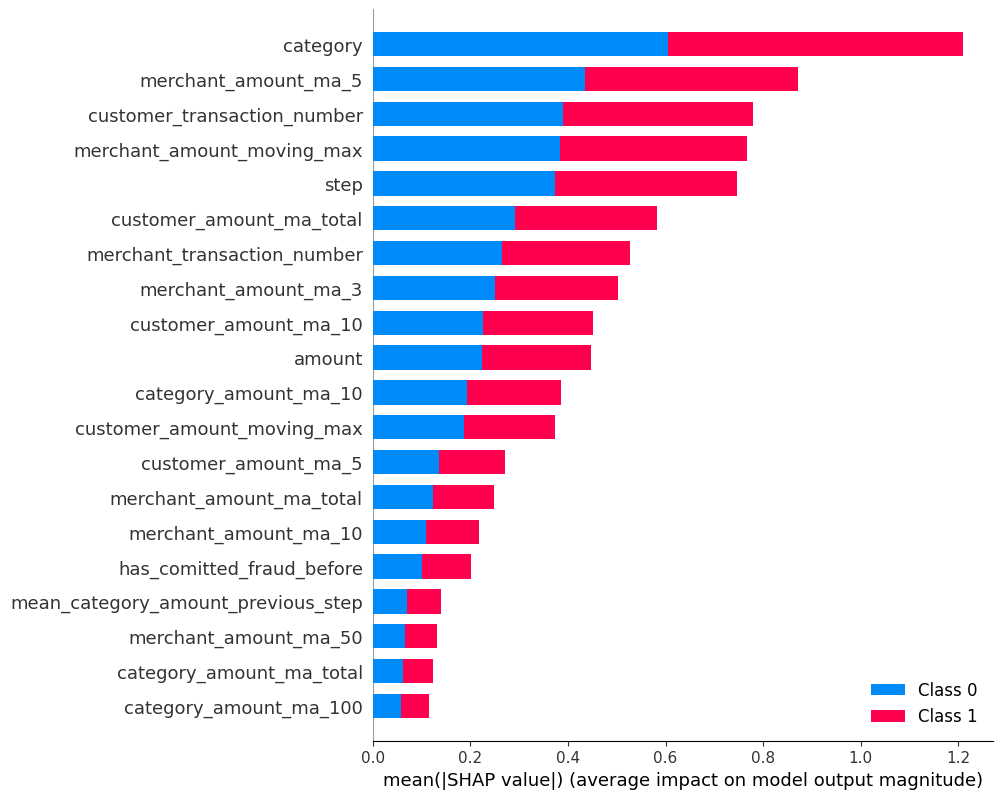

In [28]:
shap.summary_plot(shap_values, explain_data)